<a href="https://colab.research.google.com/github/yuchenhe-xai/yccolab/blob/main/241113_scoring_data_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scores for data learnability
As discussed in [doc](https://docs.google.com/document/d/1msVlIjZwDUNpwalNuJ60P-9ieSINEVsC5ItyIBPUHPk/edit?tab=t.0#heading=h.y24asf17gdl1) - we want to find the data distributions that worth labeling and RL against. Besides matching the distribution based on clustering and categories, here we are defining a score approximating the learnability. Our assumption is that examples with lower score is more learnable - aka policy's entropy would decreases significantly after training - model could learn from it.

Here are 4 different options, note ${a}$ is the LLM token output, $p = p_\text{target}(a|s)$ is the target policy after RL, $q = p_\text{ref}(a|s)$ is the original SFT policy.
- probability ratio (similar in ppo's off-policy importance weight) : $s_\text{p} = p/q $ (?? higher means p is more certain?)
- entropy gap $s_\text{inverse_entropy} = p \log p - q \log q $ (higher means p is lower entropy and more certain)
- cross entropy: $s_\text{ce} = - p \log q$  (lower means p is more certain)
- kl divergence: $s_\text{kl} = p \log (p/q)$  (higher means p is more certain)
- Jensen-Shannon Divergence $s_\text{jsd} = 0.5 s_\text{kl}(p || m) +  0.5 s_\text{kl}(q || m) $. (higher means p is more different , not necessary more certain)

Here we wrap this into a reward client to be used downstream.

In [2]:
#@title imports

import aiohttp
import asyncio
import numpy as np
import pandas as pd
import glob
from enum import Enum
from tqdm import tqdm
from typing import Any
from xlm.config import Config
from xlm.config import configclass
from xlm.posttrain import utils
from xlm.posttrain.data import formatting
from xlm.sampling_client import SamplingClient
from xlm.tokenizers.constants import get_tokenizer, Tokenizer

In [3]:
#@title define scorer
DEFAULT_TOKENIZER = get_tokenizer("v4")
SFT_MODEL = "v5l-1010-sft-rubrics-sglang.yuchen.svc.max.x.ai"
POLICY_MODEL = "v5l-inf-mb-sglang.yuchen.svc.max.x.ai"

SFT_MODEL = "sft-base-sglang.yuchen.svc.max.x.ai"
POLICY_MODEL = "pmix-org-128k-800s-sglang.yuchen.svc.max.x.ai"

class ScoreType(Enum):
  P = 0
  CE = 1
  KL = 2
  IE = 3
  JSD = 4

@configclass
class RelativeScorer(Config):
    tokenizer: Tokenizer = DEFAULT_TOKENIZER
    timeout: int = 100
    model_addr: str = POLICY_MODEL
    model_addr_ref: str = SFT_MODEL
    max_parallel: int = 1024
    semaphore = asyncio.Semaphore(value=max_parallel)

    async def get_logprob(self, prompt: str, response: str, model_addr: str = None) -> float:
        """Compute the log probabilities for response"""
        prompt_tokens = self.tokenizer.tokenize_no_eos(prompt)
        suffix_prob = np.inf
        async with self.semaphore:
            async with aiohttp.ClientSession(
                timeout=aiohttp.ClientTimeout(total=self.timeout)
            ) as session:
                logp_response = await session.post(
                    f"http://{model_addr}:30000/generate",
                    json={
                        "text": prompt + response,
                        "sampling_params": {"temperature": 0, "max_new_tokens": 0},
                        "return_logprob": True,
                        "logprob_start_len": len(prompt_tokens) - 1,
                    },
                )
                response_json = await logp_response.json()
                suffix_logprobs = response_json["meta_info"]["input_token_logprobs"]
                logprobs = [ri[0] for ri in suffix_logprobs]
                suffix_prob = np.exp(np.mean(logprobs)).item()
        return suffix_prob

    async def get_scores(self, prompt: str, response: str):
        """
        Compute the scores for response
        note ${a}$ is the LLM token output, $p = p_\text{target}(a|s)$ is the target policy after RL, $q = p_\text{ref}(a|s)$ is the original SFT policy.
        - probability ratio (similar in ppo's off-policy importance weight) : $s_\text{p} = p/q $ (?? higher means p is more certain?)
        - entropy gap $s_\text{inverse_entropy} = p \log p - q \log q $ (higher means p is lower entropy and more certain)
        - cross entropy: $s_\text{ce} = - p \log q$  (lower means p is more certain)
        - kl divergence: $s_\text{kl} = p \log (p/q)$  (higher means p is more certain)
        - Jensen-Shannon Divergence $s_\text{jsd} = 0.5 s_\text{kl}(p || m) +  0.5 s_\text{kl}(q || m) $. (higher means p is more different , not necessary more certain)
        """
        p_target = await self.get_logprob(prompt, response, model_addr=self.model_addr)
        p_ref = await self.get_logprob(prompt, response, model_addr=self.model_addr_ref)
        logp_m = np.log((p_target + p_ref) / 2 )
        logp_target = np.log(p_target)
        logp_ref = np.log(p_ref)
        score_p = np.exp(logp_target - logp_ref)
        score_ce = -logp_target * p_ref
        score_kl = p_target * (logp_target - logp_ref)
        score_inv_entropy = logp_target * p_target - logp_ref * p_ref
        score_jsd = 0.5 * p_target * (logp_target - logp_m) + 0.5 * p_ref * (logp_ref - logp_m)
        scores = {
            "score_p": score_p,
            "score_ce": score_ce,
            "score_kl": score_kl,
            "score_inv_entropy": score_inv_entropy,
            "score_jsd": score_jsd,
            "logp_target": logp_target,
            "logp_ref": logp_ref,
        }
        return scores

In [3]:
scorer = RelativeScorer()
await scorer.get_scores(prompt="asdfs", response="dx")


{'score_p': 0.9998749693616341,
 'score_ce': -0.00015930273926557345,
 'score_kl': -0.0001250583702399591,
 'logp_target': 0.00015925745658518597,
 'logp_ref': 0.0002842959119330156}

In [4]:
#@title a new reward client that does scoring
from xlm.reward_client import RewardClient
from dataclasses import field

@configclass
class RelativeRewardClient(RewardClient):
    model_addr: str = POLICY_MODEL
    model_addr_ref: str = SFT_MODEL
    scorer: RelativeScorer = None
    num_samples: int = 1 # if we do monte carlo sampling

    def __post_init__(self):

        # if response is not provided or we want to use a specific model response, we set up the sampling client for it
        if self.address.endswith("/"):
          self.address = self.address[:-1]
        self.sampling_client = SamplingClient()
        self.model = self.address.split("/")[0]
        self.sampling_client._grok_client.register_model(
           model=self.model, model_address=self.address, max_parallel=self.max_parallel
        )
        self.semaphore = asyncio.Semaphore(value=self.max_parallel)
        if self.scorer is None:
          self.scorer = RelativeScorer(
              model_addr=self.model_addr, model_addr_ref=self.model_addr_ref,
          )


    async def _generate(
        self, messages: list[dict[str, str]] = None, example: dict[str, Any] = None
    ) -> dict[str, Any]:
        try:
            async with self.semaphore:
                prompt = example.get("prompt", None)
                response = example.get("response", None)
                if messages is not None:
                    if messages[-1]["role"] in ["ASSIS", "assistant"]:
                        prompt = formatting.render_conversation(name="grok", messages=messages[:-1])
                        response = messages[-1]["content"]
                    else:
                        prompt = formatting.render_conversation(name="grok", messages=messages)
                scores = {}
                scores_raw_data = {}
                if response is not None:
                    scores = await self.scorer.get_scores(prompt=prompt, response=response)
                else:
                    scores_all = []
                    responses_all = []
                    for _ in range(self.num_samples):
                        response_i = await self.sampling_client.generate(
                            prompt=prompt, model=self.model
                        )
                        score_i = await self.scorer.get_scores(prompt=prompt, response=response_i)
                        scores_all += [score_i]
                        responses_all += [response_i]
                    scores_raw_data = dict(zip(responses_all, scores_all))
                    keys = scores_all[0].keys()
                    scores = {k: sum(s[k] for s in scores_all) / self.num_samples for k in keys}
                    example["scores_raw_data"] = scores_raw_data
                example["scores"] = scores
                return scores
        except Exception as e:
            print(e)
            traceback.print_exc()
            return None

AssertionError: Duplicate Config Class RelativeScorer

In [5]:
prompt = """Human: You will classify what genre each book is based on its summary.  When answering give both the genre name and a short (1-2 sentences) justification for why it is that genre.  If a book could be classified as multiple genres pick the one that fits the best. Here are the genres:

[Fantasy]: A genre of imaginative fiction involving magic and adventure, especially in a setting other than the real world
[Science Fiction]: A form of fiction that deals principally with the impact of actual or imagined science upon society or individuals.
[Dystopian]: A popular genre of science fiction, dystopian novels offer a bleak and frightening vision of the future.
[Action & Adventure]: The protagonist has a very important goal to achieve, but they’re going to have to go through the wringer first! The hero experiences obstacle after obstacle and goes through downright dangerous situations but eventually, they triumph and return home transformed.
[Mystery]: Also called detective fiction, this book genre is characterized by a gripping plot that revolves around a mystery.
 [Historical Fiction]: This book genre encompasses fictional stories in a historical setting, carefully balancing creativity and facts. In most cases, the characters and events are imagined by the author and enriched with historically accurate details from a specific time period.
[Romance]:  The key thing to remember is that the romantic relationship must be the center point of the plot. (Other giveaways include a “happily ever after” ending and the warm fuzzies.)
[Contemporary Fiction]: This book genre is occasionally lumped in with others to indicate that the book takes place in the present day. But in its simplest form, contemporary fiction is better understood as the absence of a genre. Your book doesn’t need tropes and trappings, monsters and mysteries, when its tension, drama, and conflict lies in the quirks and quandaries of your protagonist’s everyday life: work, politics, relationships, and the struggles of the modern era.
[Literary Fiction]: Like contemporary fiction, books considered literary fiction can’t be neatly filed under any other genre. What distinguishes this genre from contemporary fiction is that works of literary fiction are thought to have considerable artistic value. If your prose is meant to engage the reader in thought, if your narrative is character-driven and introspective, and if you provide personal or social commentary on a “serious” theme, then chances are you’re writing lit-fic

Your output should consist of the name of the genre in bold followed by the 1-2 sentence justification for why the book is considered to be that genre.

Classify this book based on the summary:

Crown of Secrets by Melanie Cellier
Verene is a disappointment to her entire kingdom--the first royal ever born without power, despite her mother being the most powerful mage in history. So when she's sent to the Academy in neighboring Kallorway to forge ties with her people's traditional enemies, she's determined to succeed and prove she can still be of value to her kingdom.

Prince Darius of Kallorway is the strongest mage in his family--and the only reason his weak father is still clinging to his throne. Starting at the Academy at the same time as Verene, the crown prince is cold and distant and shows no desire to connect with her. Instead he seems suspicious of both her presence and her claimed lack of power.

Surrounded by unfamiliar politics and long-held enemies, Verene discovers that some at the Academy want her gone by whatever means necessary. As the threats grow ever more sinister, she starts to question all of her assumptions. The hardened prince might just be her best hope of survival and--even more shockingly--he might be right about her power. If Verene wants to survive Kallorway and the Academy, she must uncover her hidden powers and take her true place among the mages.<|separator|>

Assistant:""".strip()
# response = "This book is classified as fantasy because it involves a world with magic and mages, which is a classic element of fantasy settings, and the plot revolves around magical powers and political intrigue in an imagined kingdom."
example = {"prompt": prompt} #  "response": response}

rr = RelativeRewardClient(address=POLICY_MODEL, num_samples=8)
await rr._generate(example=example)

NameError: name 'RelativeRewardClient' is not defined

In [11]:
#@title example of wrapping the scoring into a data processing of preference data

# for new policy answer - if we dont have a model generated response yet
DEFAULT_MODEL = "v5l-1101-crm.yuchen.svc.max.x.ai"

sampling_client = SamplingClient()
sampling_client._grok_client.register_model(
    model=DEFAULT_MODEL, model_address=DEFAULT_MODEL
)
scorer = RelativeScorer()

# for preference data: we get conversation from the preference conversation0/1 set and we are rating the latest of the reponses
async def process_preference_data(
    input_path, output_path, sampling_client = None, semaphore = None, pbar=None, scorer: RelativeScorer = scorer
):
    df1 = utils.read_df(glob.glob(input_path))
    row_pbar = tqdm(total=len(df1), desc=f"Processing {input_path}", leave=False)
    async def process_row(example):
        example = example.to_dict() if not isinstance(example, dict) else example
        reward = None
        conv = example.get('conversation0')[:-1]
        prompt = formatting.render_conversation(name="grok", messages=conv) if conv is not None else None
        if sampling_client:
          response = sampling_client.generate(prompt=prompt)
        else:
          model_id_0 = example.get("model_0_id")
          model_id_1 =  example.get("model_1_id")
          if "grok" in model_id_0 and "grok" in model_id_1:
            chosen_model = 0 if example.get("model_0_id") > example.get("model_1_id") else 1
          elif "grok" in model_id_0:
            chosen_model = 0
          elif "grok" in model_id_1:
            chosen_model = 1
          else:
            chosen_model = 0
          response = example.get(f'conversation{chosen_model}', [])[-1]["content"]
        scores = await scorer.get_scores(prompt, response)
        example.update({"entropy_scores": scores})
        row_pbar.update(1)
        return example
    # Process in batches
    batch_size = 10_000  # len(df1) #  1000  # Adjust this based on your system's capacity
    mapped_data = []
    for start in range(0, len(df1), batch_size):
        batch = df1.iloc[start : start + batch_size]
        batch_results = await asyncio.gather(
            *(process_row(example) for _, example in batch.iterrows())
        )
        mapped_data.extend(batch_results)

    df2 = pd.DataFrame(mapped_data)
    def getentropygap(row):
        return row['entropy_scores']['gap_score']

    # Apply the function to create a new column or use directly for sorting
    # Here, we create a temporary column for clarity, but you can also sort directly
    df2['temp_entropy_gap'] = df2.apply(getentropygap, axis=1)

    # Now sort the DataFrame by the temporary column
    df2_sorted = df2.sort_values(by='temp_entropy_gap', ascending=True)

    utils.df_to_parquet(df2_sorted, output_path)
    return df2_sorted

[2024-11-15 00:43:46,473 E] [colabbox-0:1619717] sampling_client:1010: bedrock setup failed: The config profile (key0) could not be found


In [13]:
#@title example of wrating the scoring into a data processing of rl data

DEFAULT_REALTIVE_REWARD_CLIENT = RelativeRewardClient(address=POLICY_MODEL)
# for preference data: we get conversation from the preference conversation0/1 set and we are rating the latest of the reponses
async def process_rl_data(
    input_path, output_path, sampling_client = None, semaphore = None, pbar=None, scorer_client: RelativeRewardClient = DEFAULT_REALTIVE_REWARD_CLIENT, scorer_type: ScoreType = ScoreType.KL
):
    score_name = scorer_type.name.lower()
    output_path = output_path.replace(".parquet",  score_name + ".parquet")
    df1 = utils.read_df(glob.glob(input_path)).iloc[0:10]
    row_pbar = tqdm(total=len(df1), desc=f"Processing {input_path}", leave=False)
    async def process_row(example):
        scores = await scorer_client._generate(example=example)
        row_pbar.update(1)
        return example
    # Process in batches
    batch_size = 10_000  # len(df1) #  1000  # Adjust this based on your system's capacity
    mapped_data = []
    for start in range(0, len(df1), batch_size):
        batch = df1.iloc[start : start + batch_size]
        batch_results = await asyncio.gather(
            *(process_row(example) for _, example in batch.iterrows())
        )
        mapped_data.extend(batch_results)

    df2 = pd.DataFrame(mapped_data)
    def getentropygap(row):
        return row['scores'].get(f'score_{score_name}', np.inf)

    # Apply the function to create a new column or use directly for sorting
    # Here, we create a temporary column for clarity, but you can also sort directly
    df2['temp_entropy_gap'] = df2.apply(getentropygap, axis=1)

    # Now sort the DataFrame by the temporary column
    df2_sorted = df2.sort_values(by='temp_entropy_gap', ascending=True)

    utils.df_to_parquet(df2_sorted, output_path)
    return df2_sorted

[2024-11-15 02:57:31,242 E] [colabbox-0:1661815] sampling_client:1010: bedrock setup failed: The config profile (key0) could not be found


In [9]:
#@title load the dumped files and reorder them accordingly

# input_folder = "/data/datasets/rubrics/mixtures/policy/mix-rubrics-8k/df.parquet"
# output_path = "/data/datasets/rubrics/mixtures/policy/mix-rubrics-8k-reorder/df_kl"
# newdata = await process_rl_data(input_folder, output_path)


In [7]:
# output_path = "/data/datasets/rubrics/mixtures/policy/mix-rubrics-8k-reorder/df_kl1/*.parquet"

# newdata = utils.read_df(glob.glob(output_path))
# newdata

In [8]:
# newdata.columns

In [59]:
!mkdir /data/datasets/rubrics/mixtures/policy/mix-rubrics-8k-reorder/df_inv_entropy1_dsc
newdata = newdata
score_name = 'ce'
score_name = "inv_entropy"
def getentropygap(row):
    return row['scores_learnability'].get(f'score_{score_name}', -np.inf)

# def getentropygap(row):
#     return row['scores_learnability'].get('logp_target') * np.exp( row['scores_learnability'].get('logp_target') ) - row['scores_learnability'].get('logp_ref') * np.exp(row['scores_learnability'].get('logp_ref') )


# Apply the function to create a new column or use directly for sorting
# Here, we create a temporary column for clarity, but you can also sort directly
newdata[f'temp_{score_name}'] = newdata.apply(getentropygap, axis=1)

newdata = newdata.sort_values(by=f'temp_{score_name}', ascending=False)
newdata.to_parquet(f"/data/datasets/rubrics/mixtures/policy/mix-rubrics-8k-reorder/df_{score_name}1_dsc/df.parquet")

In [61]:
newdata['temp_kl'] = newdata['temp_entropy_gap']

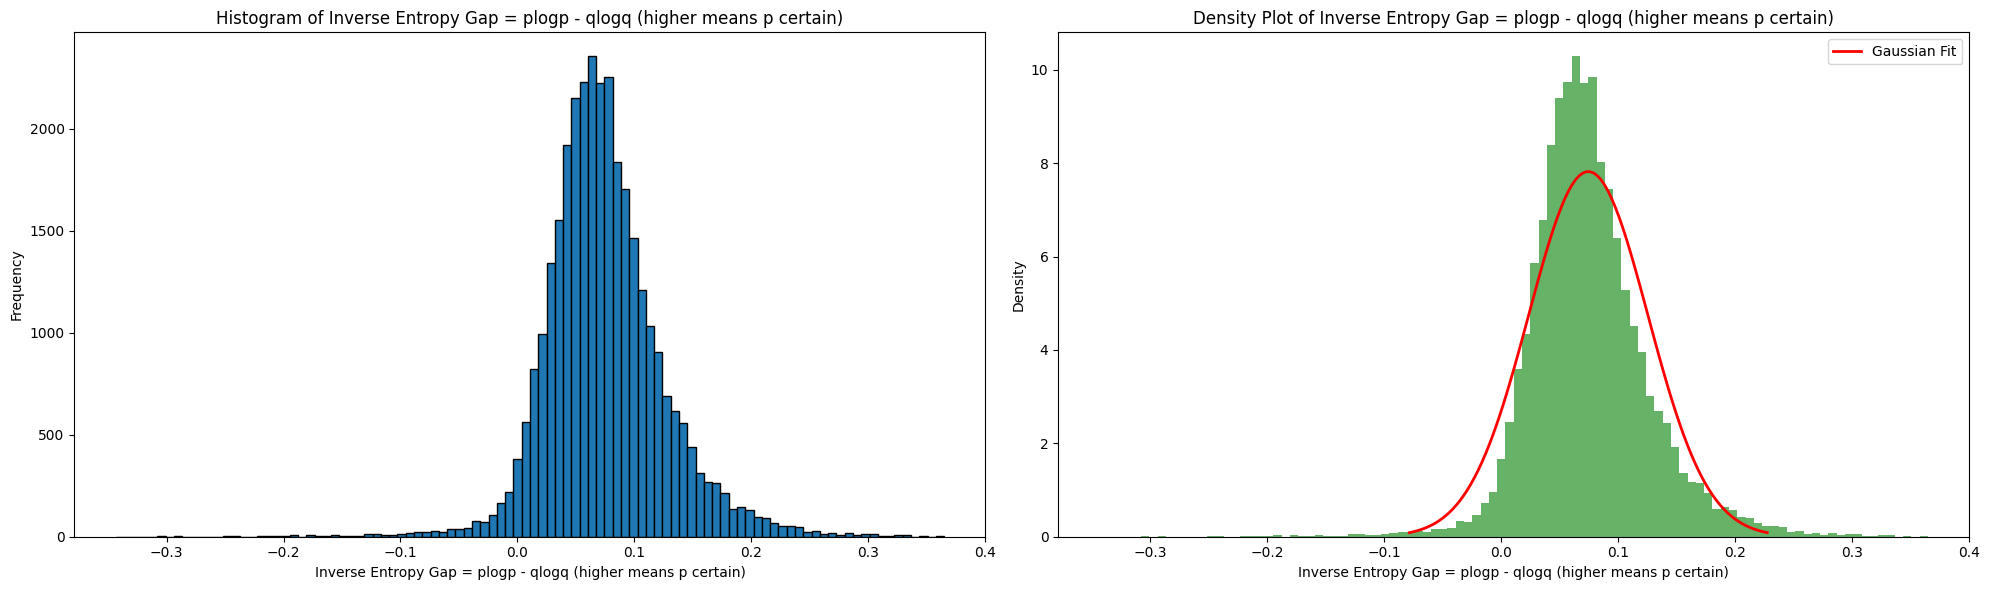

In [65]:
#@title visualize the distributions of the scores

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
# Assuming the dataset is in a CSV file named 'newdata.csv'

# Extracting the column of interest for plotting

col = "temp_inv_entropy"
name = "Inverse Entropy Gap = plogp - qlogq (higher means p certain)"

# col = "temp_kl"
# name= "KL divergence = plog(p/q)  (higher means p certain )"

# col = "temp_p_ratio"
# name = "P ratio = p/q (higher means p certain)"

# col = "temp_ce"
# name = "Cross Entropy = -plogq (higher means p certain)"


temp_entropy_gap = newdata[col]

# Creating figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plotting histogram
n, bins, patches = ax1.hist(temp_entropy_gap, bins=100, edgecolor='black')
ax1.set_title(f'Histogram of {name}')
ax1.set_xlabel(name)
ax1.set_ylabel('Frequency')

# Plotting a density plot
ax2.hist(temp_entropy_gap, bins=100, density=True, alpha=0.6, color='g')
mu, sigma = np.mean(temp_entropy_gap), np.std(temp_entropy_gap)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax2.plot(x, 1/(sigma * np.sqrt(2*np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2)),
         linewidth=2, color='r', label='Gaussian Fit')
ax2.set_title(f'Density Plot of {name}')
ax2.set_xlabel(name)
ax2.set_ylabel('Density')
ax2.legend()

# Showing the plot
plt.tight_layout()
plt.show()

In [20]:
temp_entropy_gap.describe()

count    24296.000000
mean         0.335365
std          0.193703
min         -0.252056
25%          0.205531
50%          0.290752
75%          0.416485
max          2.217359
Name: temp_entropy_gap, dtype: float64